# Self made SVD

In [1]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [2]:
# Done similarly to https://github.com/albertauyeung/matrix-factorization-in-python
from tqdm import tqdm

class SVD():
    
    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui=train_ui
        self.uir=list(zip(*[train_ui.nonzero()[0],train_ui.nonzero()[1], train_ui.data]))
        
        self.learning_rate=learning_rate
        self.regularization=regularization
        self.iterations=iterations
        self.nb_users, self.nb_items=train_ui.shape
        self.nb_ratings=train_ui.nnz
        self.nb_factors=nb_factors
        
        self.Pu=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_users, self.nb_factors))
        self.Qi=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_items, self.nb_factors))

    def train(self, test_ui=None):
        if test_ui!=None:
            self.test_uir=list(zip(*[test_ui.nonzero()[0],test_ui.nonzero()[1], test_ui.data]))
            
        self.learning_process=[]
        pbar = tqdm(range(self.iterations))
        for i in pbar:
            pbar.set_description(f'Epoch {i} RMSE: {self.learning_process[-1][1] if i>0 else 0}. Training epoch {i+1}...')
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            if test_ui==None:
                self.learning_process.append([i+1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append([i+1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)])
    
    def sgd(self, uir):
        
        for u, i, score in uir:
            # Computer prediction and error
            prediction = self.get_rating(u,i)
            e = (score - prediction)
            
            # Update user and item latent feature matrices
            Pu_update=self.learning_rate * (e * self.Qi[i] - self.regularization * self.Pu[u])
            Qi_update=self.learning_rate * (e * self.Pu[u] - self.regularization * self.Qi[i])
            
            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update
        
    def get_rating(self, u, i):
        prediction = self.Pu[u].dot(self.Qi[i].T)
        return prediction
    
    def RMSE_total(self, uir):
        RMSE=0
        for u,i, score in uir:
            prediction = self.get_rating(u,i)
            RMSE+=(score - prediction)**2
        return np.sqrt(RMSE/len(uir))
    
    def estimations(self):
        self.estimations=\
        np.dot(self.Pu,self.Qi.T)

    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [3]:
model=SVD(train_ui, learning_rate=0.005, regularization=0.02, nb_factors=100, iterations=40)
model.train(test_ui)

Epoch 39 RMSE: 0.7503496297849689. Training epoch 40...: 100%|██████████| 40/40 [01:12<00:00,  1.81s/it]


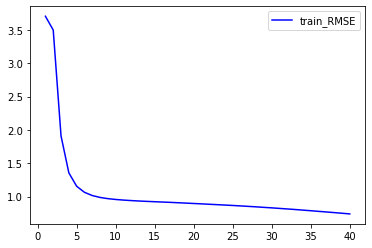

In [4]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process).iloc[:,:2]
df.columns=['epoch', 'train_RMSE']
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.legend()

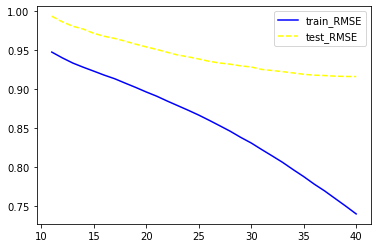

In [5]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process[10:], columns=['epoch', 'train_RMSE', 'test_RMSE'])
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.plot('epoch', 'test_RMSE', data=df, color='yellow', linestyle='dashed')
plt.legend()

#### Saving and evaluating recommendations

In [6]:
model.estimations()

top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_SVD_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', index=False, header=False)

In [7]:
import evaluation_measures as ev

estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_SVD_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 10387.88it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  0.91633  0.720153   0.103393  0.044455  0.053177  0.070073   

   precision_super  recall_super      NDCG       mAP      MRR      LAUC  \
0         0.093884      0.079366  0.107792  0.051281  0.20021  0.518957   

        HR  Reco in test  Test coverage   Shannon      Gini  
0  0.47508      0.853022       0.147186  3.911356  0.971196

In [8]:
import evaluation_measures as ev

dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 10057.03it/s]
943it [00:00, 10623.82it/s]
943it [00:00, 9952.71it/s]
943it [00:00, 10166.90it/s]
943it [00:00, 10805.10it/s]
943it [00:00, 10623.82it/s]
943it [00:00, 10390.37it/s]
943it [00:00, 10166.95it/s]
943it [00:00, 11057.98it/s]
943it [00:00, 10170.01it/s]
943it [00:00, 10994.41it/s]
943it [00:00, 10390.45it/s]
943it [00:00, 10166.77it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0            Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0               Self_SVD  0.916330  0.720153   0.103393  0.044455  0.053177   
0         Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0         Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0           Ready_Random  1.510030  1.211848   0.050053  0.022367  0.025984   
0            Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0  Ready_I-KNNWithZScore  0.957701  0.752387   0.003712  0.001994  0.002380   
0   Ready_I-KNNWithMeans  0.935327  0.737424   0.002545  0.000755  0.001105   
0    Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0            Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0          Self_TopRated  2.508258  2.217909   0.000954  0.000188  0.000298   
0        Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0              Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.070073         0.093884      0.079366  0.107792  0.051281  0.200210   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.033727         0.030687      0.023255  0.055392  0.021602  0.137690   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.002919         0.003433      0.002401  0.005137  0.002158  0.016458   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR  Reco in test  Test coverage   Shannon      Gini  
0  0.555546  0.765642      1.000000       0.038961  3.159079  0.987317  
0  0.518957  0.475080      0.853022       0.147186  3.911356  0.971196  
0  0.515501  0.437964      1.000000       0.033911  2.836513  0.991139  
0  0.509546  0.384942      1.000000       0.025974  2.711772  0.992003  
0  0.507713  0.338282      0.987911       0.187590  5.111878  0.906685  
0  0.499885  0.154825      0.402333       0.434343  5.133650  0.877999  
0  0.497349  0.027572      0.389926       0.067821  2.475747  0.992793  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496441  0.007423      0.602121       0.010823  2.089186  0.995706  
0  0.496433  0.009544      0.699046       0.005051  1.945910  0.995669  
0  0.496424  0.009544      0.600530       0.005051  1.803126  0.996380  
0  0.496391  0.003181      0.392153       0.115440  4.174741  0.965327

### Embeddings

In [9]:
x=np.array([[1,2],[3,4]])
display(x)
x/np.linalg.norm(x, axis=1)[:,None]

array([[1, 2],
       [3, 4]])

array([[0.4472136 , 0.89442719],
       [0.6       , 0.8       ]])

In [10]:
item=random.choice(list(set(train_ui.indices)))

embeddings_norm=model.Qi/np.linalg.norm(model.Qi, axis=1)[:,None] # we do not mean-center here
# omitting normalization also makes sense, but items with a greater magnitude will be recommended more often

similarity_scores=np.dot(embeddings_norm,embeddings_norm[item].T)
top_similar_items=pd.DataFrame(enumerate(similarity_scores), columns=['code', 'score'])\
.sort_values(by=['score'], ascending=[False])[:10]

top_similar_items['item_id']=top_similar_items['code'].apply(lambda x: item_code_id[x])

items=pd.read_csv('./Datasets/ml-100k/movies.csv')

result=pd.merge(top_similar_items, items, left_on='item_id', right_on='id')

result

code     score  item_id    id                                        title  \
0  1311  1.000000     1312  1312                 Pompatus of Love, The (1996)   
1  1395  0.992638     1396  1396                             Stonewall (1995)   
2  1448  0.991954     1449  1449                       Pather Panchali (1955)   
3  1201  0.991726     1202  1202  Maybe, Maybe Not (Bewegte Mann, Der) (1994)   
4  1405  0.991419     1406  1406                 When Night Is Falling (1995)   
5  1250  0.991108     1251  1251                        A Chef in Love (1996)   
6  1263  0.991100     1264  1264                       Nothing to Lose (1994)   
7  1123  0.991069     1124  1124                   Farewell to Arms, A (1932)   
8  1110  0.991040     1111  1111                      Double Happiness (1994)   
9  1124  0.990889     1125  1125                        Innocents, The (1961)   

           genres  
0   Comedy, Drama  
1           Drama  
2           Drama  
3          Comedy  
4  Drama, Romance  
5          Comedy  
6           Drama  
7    Romance, War  
8           Drama  
9        Thriller

In [12]:
# project task 5:  implement SVD on top baseline (as it is in Surprise library)from tqdm import tqdm

class SVDBaseline():

    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui=train_ui
        self.uir=list(zip(*[train_ui.nonzero()[0],train_ui.nonzero()[1], train_ui.data]))

        self.learning_rate=learning_rate
        self.regularization=regularization
        self.iterations=iterations
        self.nb_users, self.nb_items=train_ui.shape
        self.nb_ratings=train_ui.nnz
        self.nb_factors=nb_factors

        self.Pu=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_users, self.nb_factors))
        self.Qi=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_items, self.nb_factors))

        self.b_u = np.zeros(self.nb_users)
        self.b_i = np.zeros(self.nb_items)

    def train(self, test_ui=None):
        if test_ui!=None:
            self.test_uir=list(zip(*[test_ui.nonzero()[0],test_ui.nonzero()[1], test_ui.data]))

        self.learning_process=[]
        pbar = tqdm(range(self.iterations))
        for i in pbar:
            pbar.set_description(f'Epoch {i} RMSE: {self.learning_process[-1][1] if i>0 else 0}. Training epoch {i+1}...')
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            if test_ui==None:
                self.learning_process.append([i+1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append([i+1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)])

    def sgd(self, uir):

        for u, i, score in uir:
            prediction = self.get_rating(u,i)
            e = (score - prediction)
            
            
            b_u_update = self.learning_rate * (e - self.regularization * self.b_u[u])
            b_i_update = self.learning_rate * (e - self.regularization * self.b_i[i])
            
            self.b_u[u] += b_u_update
            self.b_i[i] += b_i_update
            Pu_update=self.learning_rate * (e * self.Qi[i] - self.regularization * self.Pu[u])
            Qi_update=self.learning_rate * (e * self.Pu[u] - self.regularization * self.Qi[i])
            
            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update
        
    def get_rating(self, u, i):
        prediction = self.b_u[u] + self.b_i[i] + self.Pu[u].dot(self.Qi[i].T)
        return prediction
    
    def RMSE_total(self, uir):
        RMSE=0
        for u,i, score in uir:
            prediction = self.get_rating(u,i)
            RMSE+=(score - prediction)**2
        return np.sqrt(RMSE/len(uir))
    
    def estimations(self):
        self.estimations= self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + np.dot(self.Pu,self.Qi.T)

    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [13]:
# making changes to our implementation by considering additional parameters in the gradient descent procedure 
# seems to be the fastest option
# please save the output in 'Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv' and
# 'Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv'

# Ready-made SVD - Surprise implementation

### SVD

In [14]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD(biased=False) # to use unbiased version

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVD_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVD_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


### SVD biased - on top baseline

In [15]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD() # default is biased=True

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVDBiased_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVDBiased_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


In [16]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 9346.25it/s]
943it [00:00, 10163.97it/s]
943it [00:00, 10745.39it/s]
943it [00:00, 10228.45it/s]
943it [00:00, 10502.49it/s]
943it [00:00, 10627.14it/s]
943it [00:00, 10620.29it/s]
943it [00:00, 10991.05it/s]
943it [00:00, 9955.97it/s]
943it [00:00, 10510.36it/s]
943it [00:00, 9746.48it/s]
943it [00:00, 10164.36it/s]
943it [00:00, 10693.82it/s]
943it [00:00, 10927.37it/s]
943it [00:00, 10620.60it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0            Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0              Ready_SVD  0.949165  0.746667   0.093955  0.044969  0.051197   
0               Self_SVD  0.916330  0.720153   0.103393  0.044455  0.053177   
0         Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0        Ready_SVDBiased  0.938146  0.739917   0.086532  0.037067  0.044832   
0         Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0           Ready_Random  1.510030  1.211848   0.050053  0.022367  0.025984   
0            Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0  Ready_I-KNNWithZScore  0.957701  0.752387   0.003712  0.001994  0.002380   
0   Ready_I-KNNWithMeans  0.935327  0.737424   0.002545  0.000755  0.001105   
0    Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0            Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0          Self_TopRated  2.508258  2.217909   0.000954  0.000188  0.000298   
0        Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0              Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.065474         0.083906      0.073996  0.104672  0.048211  0.220757   
0  0.070073         0.093884      0.079366  0.107792  0.051281  0.200210   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.058877         0.078004      0.057865  0.094583  0.043013  0.202391   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.033727         0.030687      0.023255  0.055392  0.021602  0.137690   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.002919         0.003433      0.002401  0.005137  0.002158  0.016458   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR  Reco in test  Test coverage   Shannon      Gini  
0  0.555546  0.765642      1.000000       0.038961  3.159079  0.987317  
0  0.519187  0.483563      0.997985       0.204906  4.408913  0.954288  
0  0.518957  0.475080      0.853022       0.147186  3.911356  0.971196  
0  0.515501  0.437964      1.000000       0.033911  2.836513  0.991139  
0  0.515202  0.433722      0.996076       0.166667  4.168354  0.964092  
0  0.509546  0.384942      1.000000       0.025974  2.711772  0.992003  
0  0.507713  0.338282      0.987911       0.187590  5.111878  0.906685  
0  0.499885  0.154825      0.402333       0.434343  5.133650  0.877999  
0  0.497349  0.027572      0.389926       0.067821  2.475747  0.992793  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496441  0.007423      0.602121       0.010823  2.089186  0.995706  
0  0.496433  0.009544      0.699046       0.005051  1.945910  0.995669  
0  0.496424  0.009544      0.600530       0.005051  1.803126  0.996380  
0  0.496391  0.003181      0.392153       0.115440  4.174741  0.965327